In [1]:
print('Ahmed is the G.O.A.T')

Ahmed is the G.O.A.T


In [2]:
!pip install onnxruntime mediapipe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# فك الضغط

zip_path= "/content/drive/My Drive/2nd_data.zip"


In [5]:
# فك الضغط داخل المجلد
!unzip -q "$zip_path" -d /content/dataset

In [6]:
# نتأكد إن المجلدات موجودة
!ls "/content/dataset/2nd_data"

test  train  val


# ***Install and import***

In [7]:
import os, json, time, math, random, shutil, warnings
from pathlib import Path
from glob import glob

import numpy as np
import onnxruntime as ort
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# ---- ضبط عام ----
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True
try:
    cv2.setNumThreads(0)  # يقلل تعليق OpenCV في بعض بيئات كولاب
except Exception:
    pass

print("✅ Ready!")
print(f"numpy        : {np.__version__}")
print(f"opencv       : {cv2.__version__}")
print(f"mediapipe    : {mp.__version__}")
print(f"onnxruntime  : {ort.__version__}")
print(f"torch        : {torch.__version__}")

# ---- تحديد الجهاز ----
if torch.backends.mps.is_available():
    device = torch.device("mps")      # Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")     # NVIDIA GPU
else:
    device = torch.device("cpu")      # CPU
print("🖥️ Device    :", device)

# =====================================================
#             MediaPipe Holistic (وجه + يدين + جسم)
# =====================================================
mp_draw = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# للاستخدام على الصور (التدريب/الاختبار)
_MP_HOLISTIC_STATIC = mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=1,
    refine_face_landmarks=False,
    min_detection_confidence=0.6
)

# للاستخدام على الفيديو أو البث المباشر (Gradio)
_MP_HOLISTIC_STREAM = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    refine_face_landmarks=False,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.5
)

def crop_holistic_union_pil(img_pil: Image.Image, pad: int = 20):
    """
    يقصّ مستطيلاً واحدًا يضمّ جميع المعالم (اليدين + الوجه + الجسم).
    يرجّع:
      - Image.fromarray(crop_rgb): الصورة المقصوصة أو الأصل إن لم تُكتشف معالم
      - box: (x1, y1, x2, y2) أو None
    """
    # تحويل آمن إلى RGB np.uint8 (يدعم GRAY/RGBA)
    arr = np.array(img_pil)
    if arr.ndim == 2:                         # GRAY
        arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    elif arr.ndim == 3 and arr.shape[2] == 4: # RGBA -> RGB
        arr = cv2.cvtColor(arr, cv2.COLOR_RGBA2RGB)
    elif arr.ndim == 3 and arr.shape[2] == 3:
        pass
    else:
        return img_pil, None

    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)

    h, w = arr.shape[:2]

    # تشغيل ميديا بايب Holistic
    res = _MP_HOLISTIC_STATIC.process(arr)

    xs, ys = [], []

    # ---- اليدان ----
    for hand_lms in [res.left_hand_landmarks, res.right_hand_landmarks]:
        if hand_lms:
            for lm in hand_lms.landmark:
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    # ---- الوجه (نقاط مختصرة لسرعة الحساب) ----
    if res.face_landmarks:
        key_face_points = [10, 152, 234, 454, 1]  # جبين/ذقن/يسار/يمين/أنف
        fl = res.face_landmarks.landmark
        for k in key_face_points:
            if 0 <= k < len(fl):
                lm = fl[k]
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    # ---- الجسم (رأس + كتفين + وركين) ----
    if res.pose_landmarks:
        pose_ids = [0, 11, 12, 23, 24]
        pl = res.pose_landmarks.landmark
        for k in pose_ids:
            if 0 <= k < len(pl):
                lm = pl[k]
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    # في حال لم تُكتشف معالم
    if not xs:
        return img_pil, None

    # تحديد الصندوق النهائي
    x1 = max(0, min(xs) - pad)
    y1 = max(0, min(ys) - pad)
    x2 = min(w, max(xs) + pad)
    y2 = min(h, max(ys) + pad)

    # تحقق من صلاحية الصندوق
    if x2 <= x1 or y2 <= y1:
        return img_pil, None

    crop_rgb = arr[y1:y2, x1:x2]
    if crop_rgb.size == 0:
        return img_pil, None

    return Image.fromarray(crop_rgb), (x1, y1, x2, y2)

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ Ready!
numpy        : 1.26.4
opencv       : 4.11.0
mediapipe    : 0.10.21
onnxruntime  : 1.23.2
torch        : 2.8.0+cu126
🖥️ Device    : cuda


# ***Controls and Tracks***

In [10]:
from pathlib import Path
import torch, numpy as np, random, os

# === مسار البيانات الرئيسي ===
DATA_ROOT = Path("/content/dataset")

# البحث الذكي عن مجلد البيانات حتى لو تغيّر اسمه أو موقعه داخل /dataset
SPLIT_SRC = next(DATA_ROOT.glob("**/2nd_data"), None)
assert SPLIT_SRC is not None, "[ERROR] Data folder (2nd_data) not found inside /content/dataset"

# === الإعدادات العامة ===
IMG_SIZE   = 64
BATCH_SIZE = 64
EPOCHS     = 15
LR         = 1e-3
SEED       = 42

# تثبيت العشوائية لضمان ثبات النتائج (Reproducibility)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# === مجلدات التقسيم ===
train_dir = SPLIT_SRC / "train"
val_dir   = SPLIT_SRC / "val"
test_dir  = SPLIT_SRC / "test"

for d in (train_dir, val_dir, test_dir):
    assert d.is_dir(), f"[ERROR] Folder not found: {d}"

# === تعريف الكلاسات ===
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(classes)

class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

print(f"✅ Found dataset at: {SPLIT_SRC}")
print(f"📦 Train: {len(list(train_dir.glob('*/*')))} images | "
      f"Val: {len(list(val_dir.glob('*/*')))} | Test: {len(list(test_dir.glob('*/*')))}")
print(f"Number of classes: {num_classes}")
print("First 10 classes:", classes[:10])

✅ Found dataset at: /content/dataset/2nd_data
📦 Train: 34452 images | Val: 1736 | Test: 1727
Number of classes: 89
First 10 classes: ['اب', 'اثنان', 'اخ', 'اربعه', 'اسف', 'الاثنين', 'الاحد', 'الاربعاء', 'الامارات العربيه المتحده', 'البحرين']


# ***Simple data-loader for 64x64 grayscale images***

In [11]:
from PIL import Image
import cv2, mediapipe as mp, numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path

# ========== إعداد MediaPipe Holistic ==========
mp_holistic = mp.solutions.holistic
_mp_holistic_static = mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=1,              # متوازن بين السرعة والدقة
    refine_face_landmarks=False,
    min_detection_confidence=0.6
)

def crop_holistic_union_pil(img_pil: Image.Image, pad: int = 20) -> Image.Image:
    """
    🔹 يقصّ مستطيلاً واحدًا يضم جميع المعالم (اليدين + الوجه + الجسم).
    🔹 يستخدم MediaPipe Holistic لاكتشاف مواضع الإنسان كاملة.
    🔹 يرجّع الصورة الأصلية إن لم يُكتشف أي عنصر.
    """
    bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    res = _mp_holistic_static.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

    xs, ys = [], []

    # --- اليدين ---
    for hand_lms in [res.left_hand_landmarks, res.right_hand_landmarks]:
        if hand_lms:
            for lm in hand_lms.landmark:
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    # --- الوجه (نقاط رئيسية فقط لتسريع القصّ) ---
    if res.face_landmarks:
        key_face_points = [10, 152, 234, 454, 1]  # جبين، ذقن، يسار، يمين، أنف
        for k in key_face_points:
            if 0 <= k < len(res.face_landmarks.landmark):
                lm = res.face_landmarks.landmark[k]
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    # --- الجسم (كتفين، وركين، رأس) ---
    if res.pose_landmarks:
        pose_ids = [0, 11, 12, 23, 24]
        for k in pose_ids:
            if 0 <= k < len(res.pose_landmarks.landmark):
                lm = res.pose_landmarks.landmark[k]
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

    if not xs:
        return img_pil  # لم يُكتشف إنسان في الصورة

    # --- تحديد صندوق القصّ ---
    x1, x2 = max(0, min(xs) - pad), min(w, max(xs) + pad)
    y1, y2 = max(0, min(ys) - pad), min(h, max(ys) + pad)

    if x2 <= x1 or y2 <= y1:
        return img_pil

    crop = bgr[y1:y2, x1:x2]
    rgb  = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb)

# ========== Dataset مخصص يعتمد على Holistic ==========
class GrayFolderDataset(Dataset):
    def __init__(self, root: Path, class_to_idx: dict, aug=False):
        self.items = []
        self.class_to_idx = class_to_idx
        valid_exts = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}

        # نجمع كل الصور والليبلات
        for c in sorted(root.iterdir(), key=lambda p: p.name):
            if not c.is_dir():
                continue
            label = class_to_idx[c.name]
            for p in c.iterdir():
                if p.suffix.lower() in valid_exts:
                    self.items.append((p, label))

        # تحويلات بعد القصّ
        base = [
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
        if aug:
            self.tf = transforms.Compose(
                [transforms.RandomAffine(5, translate=(0.03, 0.03))] + base
            )
        else:
            self.tf = transforms.Compose(base)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")

        # ✅ استخدام Holistic بدلاً من Hands
        img = crop_holistic_union_pil(img)
        img = self.tf(img.convert("L"))
        return img, label


# ========== تحميل البيانات ==========
from torch.utils.data import DataLoader

train_ds = GrayFolderDataset(SPLIT_SRC / "train", class_to_idx, aug=True)
val_ds   = GrayFolderDataset(SPLIT_SRC / "val",   class_to_idx, aug=False)
test_ds  = GrayFolderDataset(SPLIT_SRC / "test",  class_to_idx, aug=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# فحص سريع
xb, yb = next(iter(train_dl))
print("✅ Batch loaded:", xb.shape, yb.shape)

✅ Batch loaded: torch.Size([64, 1, 64, 64]) torch.Size([64])


# ***Light weight, accurate model for 64x64 grayscale photos***

In [12]:
# ============================================================
# MobileNetV3-Small (Optimized for Holistic Input 64×64 Grayscale)
# ============================================================
from torchvision import models
import torch.nn as nn

# تحميل النموذج بدون أوزان مسبقة
model = models.mobilenet_v3_small(weights=None)

# تعديل أول طبقة لتقبل قناة واحدة (grayscale)
model.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=16,
    kernel_size=3,
    stride=2,
    padding=1,
    bias=False
)

# تعديل الطبقة النهائية حسب عدد الكلاسات
model.classifier[-1] = nn.Linear(
    in_features=model.classifier[-1].in_features,
    out_features=num_classes,
    bias=True
)

# نقل النموذج للجهاز
model = model.to(device)

# إعدادات التدريب
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# فحص حجم النموذج
params_m = sum(p.numel() for p in model.parameters()) / 1e6
print(f"✅ MobileNetV3-Small model ready with {num_classes} classes.")
print(f"Model params (M): {params_m:.3f}")

✅ MobileNetV3-Small model ready with 89 classes.
Model params (M): 1.609


# ***Training with optimal weight retention and simple Early Stop***

In [13]:
from collections import deque
from pathlib import Path
import torch

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0

    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loss_sum += loss.item() * yb.size(0)

    return loss_sum / total, correct / total


best_val_acc = 0.0
patience, bad = 4, 0
best_path = Path("./models/best_mubsir_mnetv3.pt")  # ✅ تحديث الاسم
best_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl, train=False)
    scheduler.step()

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
        f"best acc {best_val_acc:.4f}"
    )

    # حفظ النموذج الأفضل
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad = 0
        torch.save(
            {
                "model": model.state_dict(),
                "classes": classes,
                "img_size": IMG_SIZE,
            },
            best_path
        )
        print("✅ Saved best model:", best_path)
    else:
        bad += 1
        if bad >= patience:
            print("⏹️ Early stopping triggered.")
            break

    # تنظيف الذاكرة (اختياري لتحسين الأداء في كولاب)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("🏁 Best validation accuracy:", best_val_acc)

Epoch 01/15 | train loss 2.3865 acc 0.3528 | val loss 2.9037 acc 0.2189 | best acc 0.0000
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 02/15 | train loss 1.3060 acc 0.6878 | val loss 1.5268 acc 0.5950 | best acc 0.2189
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 03/15 | train loss 1.0193 acc 0.7910 | val loss 1.0946 acc 0.7356 | best acc 0.5950
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 04/15 | train loss 0.8795 acc 0.8438 | val loss 1.0700 acc 0.7736 | best acc 0.7356
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 05/15 | train loss 0.7793 acc 0.8819 | val loss 0.8146 acc 0.8681 | best acc 0.7736
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 06/15 | train loss 0.7134 acc 0.9059 | val loss 0.7400 acc 0.8900 | best acc 0.8681
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 07/15 | train loss 0.6551 acc 0.9273 | val loss 0.6795 acc 0.9228 | best acc 0.8900
✅ Saved best model: models/best_mubsir_mnetv3.pt
Epoch 08/15 | train loss 0.

# ***Test evaluation and reports***

=== Final (TEST) Metrics ===
Accuracy : 0.9867
Precision: 0.9387
Recall   : 0.9510
F1-Score : 0.9401

[Optional] Weighted Averages
Precision_w: 0.9862 | Recall_w: 0.9867 | F1_w: 0.9860

Per-class report (table):


,precision,recall,f1-score,support
اب,1.0000,0.9912,0.9956,114
اثنان,1.0000,0.5000,0.6667,2
اخ,0.5000,1.0000,0.6667,1
اربعه,1.0000,1.0000,1.0000,2
اسف,1.0000,0.9500,0.9744,20
...,...,...,...,...
يسمع,0.9808,0.9903,0.9855,103
يشرب,1.0000,1.0000,1.0000,2
macro avg,0.9071,0.9190,0.9084,1727
weighted avg,0.9862,0.9867,0.9860,1727


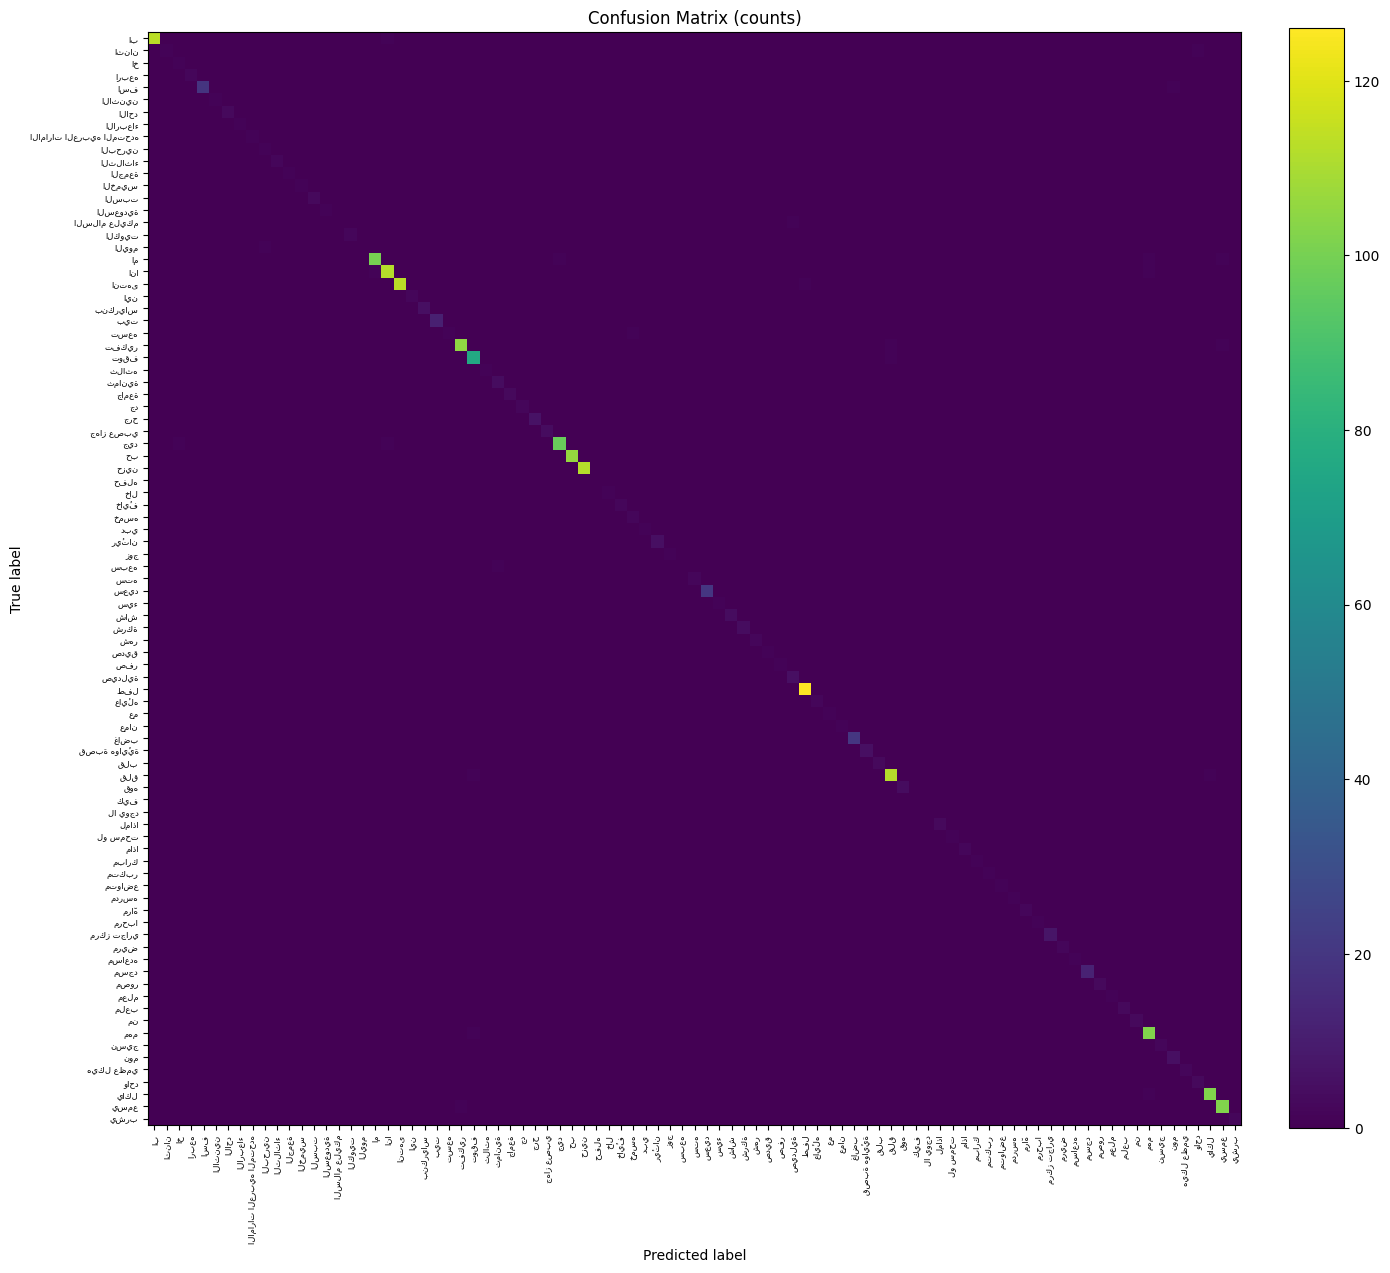

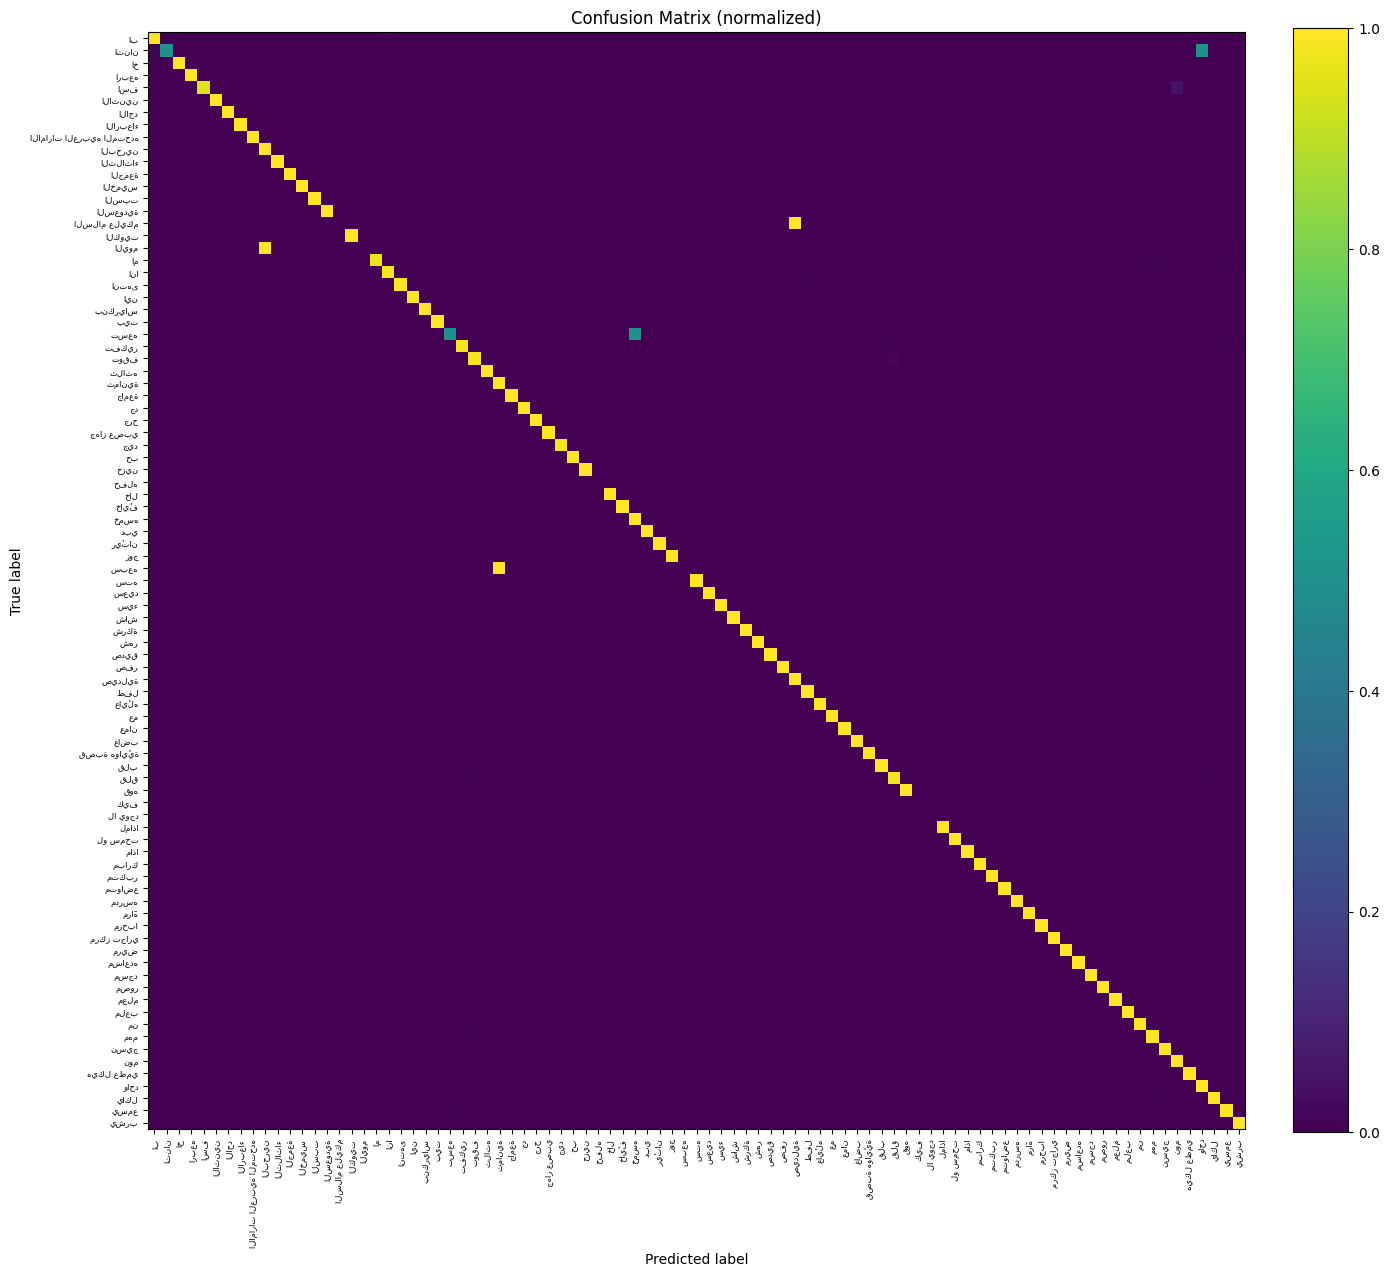

In [14]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import models
import torch.nn as nn

# نفس مسار نموذج الحفظ بعد التدريب على MobileNetV3-Small
best_path = Path("./models/best_mubsir_mnetv3.pt")

# أعِد بناء المودل بالضبط (قناة واحدة + عدد الكلاسات)
model_eval = models.mobilenet_v3_small(weights=None)
# أول طبقة تتوقع 3 قنوات، نعدّلها لقناة واحدة (صور رمادية):
first_conv = model_eval.features[0][0]
model_eval.features[0][0] = nn.Conv2d(
    in_channels=1,
    out_channels=first_conv.out_channels,
    kernel_size=first_conv.kernel_size,
    stride=first_conv.stride,
    padding=first_conv.padding,
    bias=False
)
# طبقة المصنّف النهائية حسب عدد الكلاسات
model_eval.classifier[-1] = nn.Linear(model_eval.classifier[-1].in_features, num_classes)

# حمّل الوزن
ckpt = torch.load(best_path, map_location=device)
classes = ckpt["classes"]
assert len(classes) == num_classes, "Mismatch in classes length."
model_eval.load_state_dict(ckpt["model"])
model_eval.to(device).eval()

all_preds, all_targets = [], []

with torch.inference_mode():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model_eval(xb)
        preds = logits.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_targets.extend(yb.cpu().numpy().tolist())

# المقاييس العامة
acc = accuracy_score(all_targets, all_preds)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="macro", zero_division=0
)
print("=== Final (TEST) Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec_macro:.4f}")
print(f"Recall   : {rec_macro:.4f}")
print(f"F1-Score : {f1_macro:.4f}")

prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    all_targets, all_preds, average="weighted", zero_division=0
)
print("\n[Optional] Weighted Averages")
print(f"Precision_w: {prec_w:.4f} | Recall_w: {rec_w:.4f} | F1_w: {f1_w:.4f}")

# تقرير لكل كلاس (جدول)
labels = list(range(num_classes))
report_dict = classification_report(
    all_targets,
    all_preds,
    labels=labels,
    target_names=classes,
    digits=4,
    zero_division=0,
    output_dict=True
)
df_report = pd.DataFrame(report_dict).T
ordered_index = list(classes) + [idx for idx in ["macro avg", "weighted avg", "accuracy"] if idx in df_report.index]
df_report = df_report.loc[ordered_index]
for col in ["precision", "recall", "f1-score"]:
    if col in df_report.columns:
        df_report[col] = df_report[col].apply(lambda x: f"{float(x):.4f}")
if "support" in df_report.columns:
    df_report["support"] = df_report["support"].astype(int)

print("\nPer-class report (table):")
display(df_report)

# مصفوفة الالتباس (طبيعية واختيارياً مطبّعة)
cm = confusion_matrix(all_targets, all_preds, labels=labels)

plt.figure(figsize=(14, 14))
im = plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (counts)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(num_classes), classes, rotation=90, fontsize=6)
plt.yticks(range(num_classes), classes, fontsize=6)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# نسخة مطبّعة (نِسَب) — اختياري
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)
plt.figure(figsize=(14, 14))
im2 = plt.imshow(cm_norm, interpolation="nearest", cmap="viridis")
plt.title("Confusion Matrix (normalized)")
plt.colorbar(im2, fraction=0.046, pad=0.04)
plt.xticks(range(num_classes), classes, rotation=90, fontsize=6)
plt.yticks(range(num_classes), classes, fontsize=6)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# ***Inference & Testing***
### هنا يطوال الاعمار ندرج صورة للمودل ونشوف نسبة الثقه انه يتعرف او لا او انه مودل يهبد لنا

Prediction: اثنان | Confidence: 27.85%


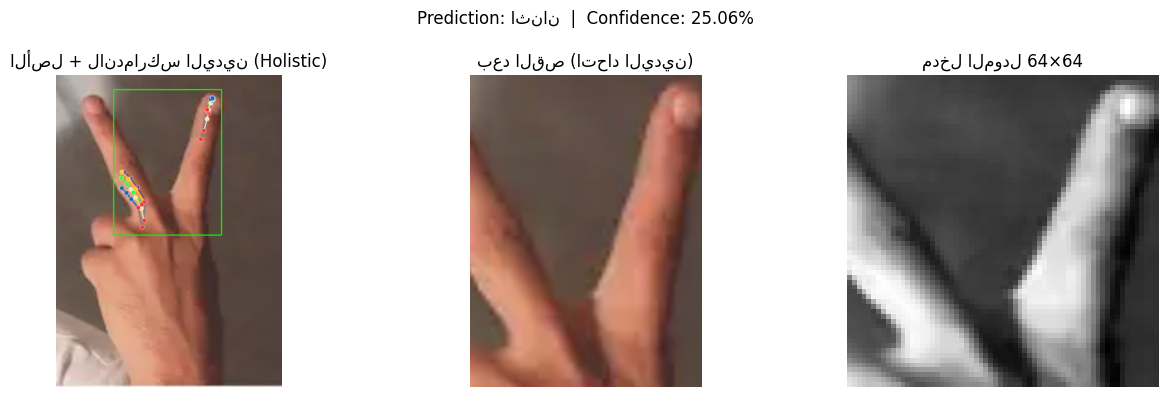

Debug Prediction: اثنان | Confidence: 25.06%
Crop box: (147, 37, 423, 409)


In [65]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mediapipe as mp
from pathlib import Path
from torchvision import transforms
import torch

# --- Holistic (نسخة الصور الثابتة) ---
_MP_HOLISTIC = mp.solutions.holistic.Holistic(
    static_image_mode=True,
    model_complexity=1,
    refine_face_landmarks=False,
    enable_segmentation=False
)
mp_draw = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

def _safe_rgb_array(img_pil: Image.Image) -> np.ndarray:
    """يحوّل أي PIL إلى RGB uint8 (يتعامل مع GRAY/RGBA)."""
    arr = np.array(img_pil)
    if arr.ndim == 2:  # GRAY
        arr = cv2.cvtColor(arr, cv2.COLOR_GRAY2RGB)
    elif arr.ndim == 3 and arr.shape[2] == 4:  # RGBA
        arr = cv2.cvtColor(arr, cv2.COLOR_RGBA2RGB)
    elif arr.ndim == 3 and arr.shape[2] == 3:
        pass
    else:
        arr = np.ascontiguousarray(arr, dtype=np.uint8)
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    return arr

def crop_hand_pil(img_pil: Image.Image, pad=20) -> Image.Image:
    """
    قص اتحاد اليدين (يمين + يسار) باستخدام Holistic.
    إن لم تُكتشف يد، تُعاد الصورة كما هي.
    """
    rgb = _safe_rgb_array(img_pil)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]

    res = _MP_HOLISTIC.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    hands = []
    if res.left_hand_landmarks:  hands.append(res.left_hand_landmarks)
    if res.right_hand_landmarks: hands.append(res.right_hand_landmarks)
    if not hands:
        return img_pil

    xs, ys = [], []
    for hand in hands:
        for lm in hand.landmark:
            xs.append(int(lm.x * w)); ys.append(int(lm.y * h))

    x1, x2 = max(0, min(xs)-pad), min(w, max(xs)+pad)
    y1, y2 = max(0, min(ys)-pad), min(h, max(ys)+pad)
    if x2 <= x1 or y2 <= y1:
        return img_pil

    crop = bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return img_pil
    return Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

def predict_image(path: Path):
    tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
    img_rgb = Image.open(path).convert("RGB")
    img_rgb = crop_hand_pil(img_rgb)                # ← Holistic hands union
    x = tf(img_rgb.convert("L")).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(1).item())
        prob = float(torch.softmax(logits, dim=1)[0, pred_idx].item())
    return idx_to_class[pred_idx], prob

def crop_hand_debug(img_pil: Image.Image, pad=20):
    """
    debug: يرجّع القص + الصندوق + صورة الأصل مع رسم لاندماركس اليدين.
    """
    rgb = _safe_rgb_array(img_pil)
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    h, w = bgr.shape[:2]
    orig_draw = bgr.copy()

    res = _MP_HOLISTIC.process(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    hands = []
    if res.left_hand_landmarks:  hands.append(("L", res.left_hand_landmarks))
    if res.right_hand_landmarks: hands.append(("R", res.right_hand_landmarks))

    # ارسم اليدين إن وُجدت
    for tag, hand_lms in hands:
        mp_draw.draw_landmarks(
            image=orig_draw,
            landmark_list=hand_lms,
            connections=mp.solutions.hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_styles.get_default_hand_landmarks_style(),
            connection_drawing_spec=mp_styles.get_default_hand_connections_style()
        )

    crop_pil, box = img_pil, None
    if hands:
        xs, ys = [], []
        for _, hand_lms in hands:
            for lm in hand_lms.landmark:
                xs.append(int(lm.x * w)); ys.append(int(lm.y * h))
        x1, x2 = max(0, min(xs)-pad), min(w, max(xs)+pad)
        y1, y2 = max(0, min(ys)-pad), min(h, max(ys)+pad)
        if x2 > x1 and y2 > y1:
            cv2.rectangle(orig_draw, (x1,y1), (x2,y2), (0,255,0), 2)
            crop = bgr[y1:y2, x1:x2]
            if crop.size > 0:
                crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                box = (x1, y1, x2, y2)

    orig_draw_rgb = cv2.cvtColor(orig_draw, cv2.COLOR_BGR2RGB)
    return crop_pil, box, Image.fromarray(orig_draw_rgb)

def predict_image_debug(path: Path, show=True):
    img_rgb = Image.open(path).convert("RGB")
    crop_pil, box, orig_with_draw = crop_hand_debug(img_rgb)

    tf_infer = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
    x = tf_infer(crop_pil.convert("L")).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x)
        pred_idx = int(logits.argmax(1).item())
        prob = float(torch.softmax(logits, dim=1)[0, pred_idx].item())
    pred_label = idx_to_class[pred_idx]

    if show:
        fig, axs = plt.subplots(1, 3, figsize=(13,4))
        axs[0].imshow(orig_with_draw); axs[0].set_title("الأصل + لاندماركس اليدين (Holistic)")
        axs[1].imshow(crop_pil);       axs[1].set_title("بعد القص (اتحاد اليدين)")
        axs[2].imshow(x[0,0].cpu(), cmap="gray"); axs[2].set_title(f"مدخل المودل {IMG_SIZE}×{IMG_SIZE}")
        for a in axs: a.axis("off")
        plt.suptitle(f"Prediction: {pred_label}  |  Confidence: {prob*100:.2f}%")
        plt.tight_layout(); plt.show()

    return pred_label, prob, box

# تجربة سريعة
sample_path = Path("/content/drive/MyDrive/Screenshot 2025-11-12 at 2.43.36 AM.png")
pred_label, confidence = predict_image(sample_path)
print("Prediction:", pred_label, "| Confidence:", f"{confidence*100:.2f}%")
pred_label, confidence, box = predict_image_debug(sample_path)
print("Debug Prediction:", pred_label, "| Confidence:", f"{confidence*100:.2f}%")
print("Crop box:", box)

In [20]:
# ============================================
# Export model to ONNX (Stable / MobileNetV3-Small)
# ============================================

!pip -q install onnx onnxruntime

import json, torch, onnx, onnxruntime as ort
from torchvision import models
import torch.nn as nn

# 1) تحميل أفضل وزن (من التدريب)
ckpt = torch.load(best_path, map_location="cpu")
classes  = ckpt["classes"]
img_size = ckpt.get("img_size", 64)

# 2) إعادة بناء MobileNetV3-Small بنفس الإعدادات ثم تحميل الأوزان
# Changed from mobilenet_v2 to mobilenet_v3_small to match the trained model
export_model = models.mobilenet_v3_small(weights=None)
export_model.features[0][0] = nn.Conv2d(
    in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False
)
export_model.classifier[-1] = nn.Linear(export_model.classifier[-1].in_features, len(classes))
export_model.load_state_dict(ckpt["model"])
export_model.eval()
export_model.cpu()  # ⚠️ التصدير من CPU أنظف

# 3) دخل تجريبي float32 بنفس شكل الإدخال الذي درّبت عليه
dummy = torch.randn(1, 1, img_size, img_size, dtype=torch.float32)

# 4) مسارات الحفظ
onnx_path = f"/content/Mubser_model_{len(classes)}cls_{img_size}.onnx"
meta_path = f"/content/Mubser_model_{len(classes)}cls_{img_size}.meta.json"

# 5) التصدير إلى ONNX (opset 13 لتوافق أعلى) + طيّ الثوابت
torch.onnx.export(
    export_model,
    dummy,
    onnx_path,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    opset_version=13,               # ✅ أوسع توافقًا
    do_constant_folding=True,       # ✅ تصغير الرسم الحسابي
    # strict=False                    # ✅ مرونة أعلى إن وُجدت فروقات طفيفة
)

print("✅ Exported:", onnx_path)

# 6) فحص سلامة ملف ONNX
m = onnx.load(onnx_path)
onnx.checker.check_model(m)
print("✅ ONNX check passed")

# 7) اختبار تشغيل سريع باستخدام ONNX Runtime (CPU)
sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
y = sess.run(None, {"input": dummy.numpy()})[0]
print("✅ ORT inference OK | output shape:", y.shape)

# 8) حفظ الميتاداتا (الفئات + حجم الإدخال) بجانب الملف
meta = {"classes": classes, "img_size": img_size}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("✅ Saved meta:", meta_path)

# 9) تحميل الملفات
from google.colab import files
files.download(onnx_path)
files.download(meta_path)

✅ Exported: /content/Mubser_model_89cls_64.onnx
✅ ONNX check passed
✅ ORT inference OK | output shape: (1, 89)
✅ Saved meta: /content/Mubser_model_89cls_64.meta.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>